In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Step 1: Load preprocessed data
X = np.load('X_preprocessed.npy')
y = np.load('y_preprocessed.npy')
print("Data loaded. X shape:", X.shape, "y shape:", y.shape)

Data loaded. X shape: (1000000, 30) y shape: (1000000,)


In [3]:
# Step 2: Define constants
EMBEDDING_DIM = 32
HIDDEN_UNITS = [64, 32]
DROPOUT_RATE = 0.3
L2_REGULARIZATION = 1e-5
LEARNING_RATE = 0.001
BATCH_SIZE = 1024
EPOCHS = 10

In [4]:
# Step 3: Split features into user and ad features
n_user_features = 7  # Adjust based on your actual number of user features
n_ad_features = X.shape[1] - n_user_features

In [5]:
X_user = X[:, :n_user_features]
X_ad = X[:, n_user_features:]
print("Features split. User features:", X_user.shape, "Ad features:", X_ad.shape)

Features split. User features: (1000000, 7) Ad features: (1000000, 23)


In [6]:
# Step 4: Define input layers
user_input = keras.layers.Input(shape=(n_user_features,), name='user_input')
ad_input = keras.layers.Input(shape=(n_ad_features,), name='ad_input')

In [7]:
# Step 5: Create tower function
def create_tower(input_layer, name_prefix):
    x = input_layer
    for i, units in enumerate(HIDDEN_UNITS):
        x = keras.layers.Dense(units, activation='relu', name=f'{name_prefix}_dense_{i}',
                               kernel_regularizer=keras.regularizers.l2(L2_REGULARIZATION))(x)
        x = keras.layers.BatchNormalization(name=f'{name_prefix}_bn_{i}')(x)
        x = keras.layers.Dropout(DROPOUT_RATE, name=f'{name_prefix}_dropout_{i}')(x)
    return x

In [8]:
# Step 6: Build user and ad towers
user_tower = create_tower(user_input, 'user')
ad_tower = create_tower(ad_input, 'ad')

In [9]:
# Step 7: Combine towers
combined = keras.layers.Concatenate()([user_tower, ad_tower])
output = keras.layers.Dense(1, activation='sigmoid', name='output')(combined)

In [10]:
# Step 8: Create model
model = keras.Model(inputs=[user_input, ad_input], outputs=output)

In [11]:
# Step 9: Define custom loss function
def weighted_binary_crossentropy(y_true, y_pred):
    pos_weight = 2.0
    neg_weight = 1.0
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    loss = -((pos_weight * y_true * tf.math.log(y_pred)) + 
             (neg_weight * (1 - y_true) * tf.math.log(1 - y_pred)))
    return tf.reduce_mean(loss)

In [12]:
# Step 10: Compile model
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss=weighted_binary_crossentropy, metrics=['accuracy', keras.metrics.AUC()])


In [13]:
# Step 11: Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)       │ (None, 7)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ad_input (InputLayer)         │ (None, 23)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_dense_0 (Dense)          │ (None, 64)                │             512 │ user_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ad_dense_0 (Dense)            │ (None, 64)                │           1,536 │ ad_input[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_bn_0                     │ (None, 64)                │             256 │ user_dense_0[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ad_bn_0 (BatchNormalization)  │ (None, 64)                │             256 │ ad_dense_0[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_dropout_0 (Dropout)      │ (None, 64)                │               0 │ user_bn_0[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ad_dropout_0 (Dropout)        │ (None, 64)                │               0 │ ad_bn_0[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_dense_1 (Dense)          │ (None, 32)                │           2,080 │ user_dropout_0[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ad_dense_1 (Dense)            │ (None, 32)                │           2,080 │ ad_dropout_0[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_bn_1                     │ (None, 32)                │             128 │ user_dense_1[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ad_bn_1 (BatchNormalization)  │ (None, 32)                │             128 │ ad_dense_1[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_dropout_1 (Dropout)      │ (None, 32)                │               0 │ user_bn_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ ad_dropout_1 (Dropout)        │ (None, 32)                │               0 │ ad_bn_1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 64)                │               0 │ user_dropout_1[0][0],      │
│                               │                           │                 │ ad_dropout_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output (Dense)                │ (None, 1)                 │              6

 Total params: 7,041 (27.50 KB)

 Trainable params: 6,657 (26.00 KB)

 Non-trainable params: 384 (1.50 KB)

In [14]:
# Step 12: Train model
history = model.fit(
    [X_user, X_ad], y,
    validation_split=0.2,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
    ]
)


Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.5558 - auc: 0.5368 - loss: 0.9796 - val_accuracy: 0.6185 - val_auc: 0.5833 - val_loss: 0.8907 - learning_rate: 0.0010
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6169 - auc: 0.5782 - loss: 0.8933 - val_accuracy: 0.6175 - val_auc: 0.5851 - val_loss: 0.8900 - learning_rate: 0.0010
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6188 - auc: 0.5813 - loss: 0.8920 - val_accuracy: 0.6083 - val_auc: 0.5837 - val_loss: 0.8903 - learning_rate: 0.0010
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6146 - auc: 0.5846 - loss: 0.8923 - val_accuracy: 0.6206 - val_auc: 0.5853 - val_loss: 0.8896 - learning_rate: 0.0010
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6174 - auc: 0.5843 - loss: 0.8915 - val_accuracy: 0.6291 - val_auc: 0.5842 - val_loss: 0.8899 - learning_rate: 0.0010
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6184 - auc: 0.

In [15]:
# Step 13: Save model (Corrected)
model.save('two_tower_nn_model.keras')  # Added .keras extension

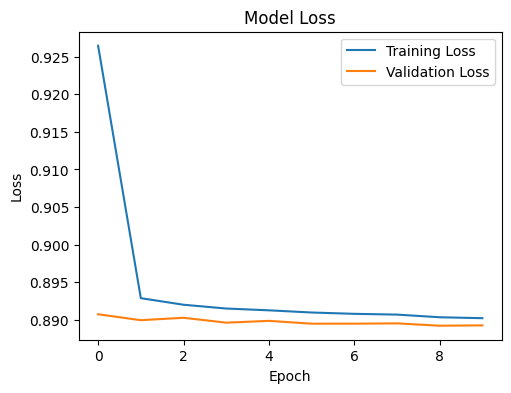

In [16]:
# Step 14: Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

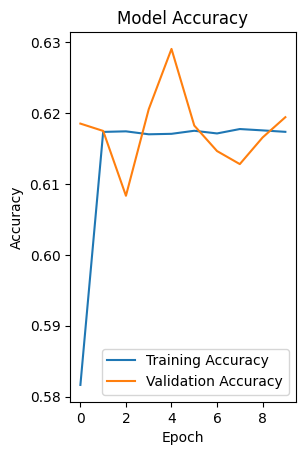

In [17]:
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [18]:
plt.tight_layout()
plt.savefig('training_history.png')
plt.close()

In [19]:
print("Model training complete. Model saved as 'two_tower_nn_model.keras'.")
print("Training history plot saved as 'training_history.png'.")

Model training complete. Model saved as 'two_tower_nn_model.keras'.
Training history plot saved as 'training_history.png'.
